In [1]:
# We import the modules that we'll need to carry out our analysis

# We use yfinance to download financial data through th yahoo finance api
import yfinance as yf

# These are general purpose data generation, manipulation, and plotting modules
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import PercentFormatter

# Statistical and optimization functions and modules
from scipy.stats import norm
import scipy.stats
from scipy.optimize import minimize

Our project is centered around the Bitcoin, the most valuable cryptocurrency, as of January 2025, which, in December 2024 surpassed the price of 100'000 dollars per unit. This was an extremely important milestone for crypto assets, as a whole.

# Part 1: Basic Analysis of Bitcoin's historical performance

### Simple Descriptive Statistics, Annualized Returns, Volatility, and Normality Check

In [9]:
# We create the Ticker object for BTC-USD and then import the 10 year time-series using the module yfinance
# Our data has daily granularity

btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period = "10y")

btc_close = btc_hist["Close"]

In [10]:
# Let's have a look at how our data looks
btc_close.head()

Date
2015-01-24 00:00:00+00:00    247.847000
2015-01-25 00:00:00+00:00    253.718002
2015-01-26 00:00:00+00:00    273.472992
2015-01-27 00:00:00+00:00    263.475006
2015-01-28 00:00:00+00:00    233.914993
Name: Close, dtype: float64

In [11]:
# Some simple descriptive statistics regarding the Bitcoin 10-year time-series
btc_close.describe().iloc[1:]

mean     20787.666108
std      23039.515190
min        210.494995
25%       2804.952515
50%       9815.709961
75%      33840.999023
max     106146.265625
Name: Close, dtype: float64

In [12]:
# We derive the time-series of daily Bitcoin returns
btc_returns_10y = btc_close.pct_change().dropna()

# We compute some simple statistics: total % returns over 10 years, and standard deviation of the daily returns
print("The total % returns we'd have made from BTC if we'd invested 10 years ago are:", 
      np.round((((btc_returns_10y+1).prod()-1)*100),2))

print("The % standard deviations for daily returns is:", np.round(np.std(btc_returns_10y),2)*100)

The total % returns we'd have made from BTC if we'd invested 10 years ago are: 42630.76
The % standard deviations for daily returns is: 4.0


#### Simplified Annualized Return Formula
$$\frac{\text{Last Price}}{\text{Initial Price}}^{\frac{1}{Years}}-1$$

In [14]:
# We compute the annualized returns for Bitcoin
annualized_returns = np.power(btc_close.iloc[-1]/btc_close.iloc[0], 1/10)-1

print("The annualized returns for BTC-USD, are:", round(annualized_returns,2))

The annualized returns for BTC-USD, are: 0.83


#### Normality Check

Now, let's check if the daily returns for BTC-USD are normally distributed. 
This is an important check to make because depending on the outcome we may or may not decide to compute the Gaussian VaR.

We're going to opt, first of all, with a graphical check. Then we're going to compute the Jarque-Bera Tests for a more rigurous check of the normality.

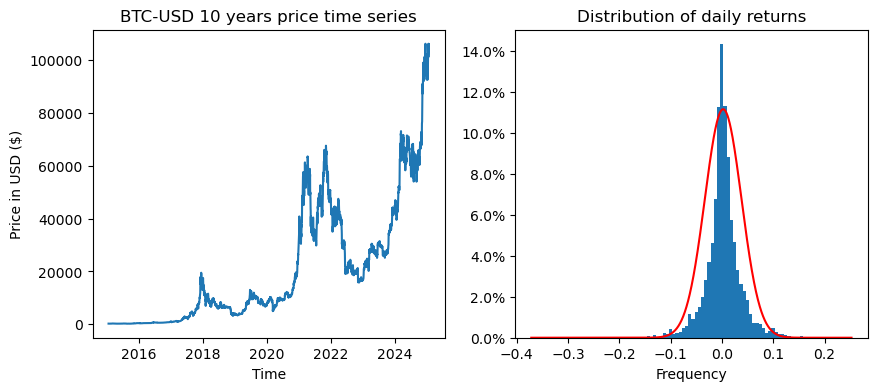

In [15]:
# We define two subplots: one for the BTC-US price time-series, and one for the distribution of daily returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

# We plot the first graph
ax1.plot(btc_close.index, btc_close.values)
ax1.set_title("BTC-USD 10 years price time series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price in USD ($)")

# We plot the second graph

# First define variables that we'll need to rescale the histogram in terms of probability, instead of frequency
len_btc_ret = len(btc_returns_10y)
weights = np.ones(len_btc_ret)/len_btc_ret*100

ax2.hist(btc_returns_10y, bins = 100, weights = weights )
ax2.set_title("Distribution of daily returns")
ax2.set_xlabel("Frequency")
# We format the yaxis in terms of percentage
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100)) 

"""
We overlap a gaussian distribution over the second graph to visually see how the distribution of returns
compares to a Gaussian.
"""
# We fit a Gaussian distribution based on the time-series of returns
mu, std = norm.fit(btc_returns_10y)
# We define the x-coordinates for the density function
x_axis_values = np.linspace(min(btc_returns_10y), max(btc_returns_10y), 1000)

# We generate the points of our density function
pdf = norm.pdf(x_axis_values, mu, std)

# We plot the Gaussian distribution over the histogram of returns
ax2.plot(x_axis_values, pdf, "r-", label = "Gaussian Fit")

# Show the plot
plt.show()

In [ ]:
# Now, we perform the Jarque-Bera test to check if returns are normally distributed

jb_stats, p_value = scipy.stats.jarque_bera(btc_returns_10y)

print(f"Jarque-Bera statistic: {jb_stats}")
print(f"p-value: {p_value}")

Jarque-Bera statistic: 8768.100215295137
p-value: 0.0


From Jarque-Bera's test, there seems to be sufficient evidence that returns are not normally distributed.
To get a deeper insight, let's look at the skewness and at the kurtosis of the data.

In [ ]:
# Calculate skewness
skewness_value = scipy.stats.skew(btc_returns_10y)

# Calculate kurtosis (Fisher's definition)
kurtosis_value = scipy.stats.kurtosis(btc_returns_10y) 

print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")

Skewness: -0.0902725425922938
Kurtosis: 7.587708338817068


While the distribution seems to be centered, like the Gaussian distribution, it's evident that the tails are fatter than the normal distribution.

### Downside Volatility: Drawdown, Semideviation, VaR, CVar

Now, let's calculate some useful risk metrics to know if we're interested in doing daily trading of Bitcoin.

In [18]:
# We defined a wealth index with a starting capital of 1000 dollars
wealth_index_btc = 1000*(1+btc_returns_10y).cumprod()
"""
We generate a time-series which stores information about peaks in the wealth time-series on a rolling basis.
We'll need this to calculate the maximum drawdown, as we'll define this in terms of wealth, 
starting from an initial capital of 1000 dollars.
"""

previous_peaks_btc = wealth_index_btc.cummax()

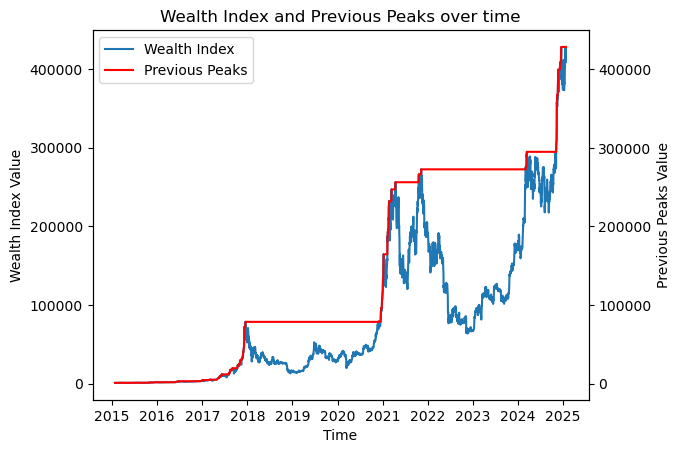

In [ ]:
# Now, let's look graphically at the time-series of wealth and its previous peaks
fig, ax = plt.subplots()

# First of all, we create a plot with a secondary y-axis
ax.plot(wealth_index_btc, label="Wealth Index") 
ax2 = ax.twinx() 
ax2.plot(previous_peaks_btc, color="r", label="Previous Peaks") 

# We set the labels for our plot
ax.set_xlabel("Time")
ax.set_ylabel("Wealth Index Value")
ax2.set_ylabel("Previous Peaks Value")
plt.title("Wealth Index and Previous Peaks over time")

# We unite the two legends into one
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left') 

plt.show()

A **drawdown** refers to how much an investment or trading account is down from the peak before it recovers back to the peak (reference: *Investopedia*), and now this is what we're going to calculate for Bitcoin, in USD terms.

<Axes: xlabel='Date'>

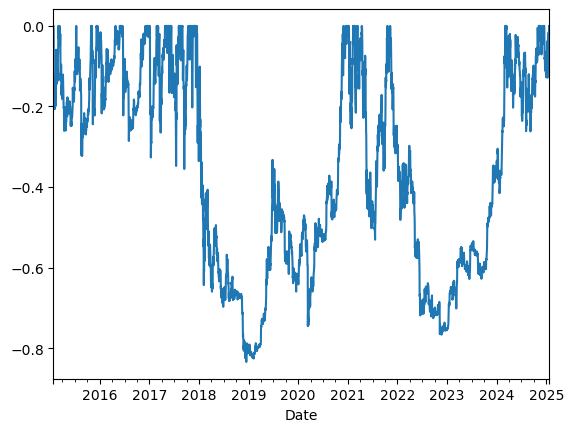

In [21]:
# We plot the drawdowns for the wealth index over time
drawdown_btc = (wealth_index_btc - previous_peaks_btc)/previous_peaks_btc
drawdown_btc.plot()

In [22]:
# Let's identify the maximum drawdown, and let's index when it happened

print(f"The maximum drawdown was: {-round(drawdown_btc.min(),2)}, which happened on {drawdown_btc.idxmin().strftime('%Y-%m-%d')}")

The maximum drawdown was: 0.83, which happened on 2018-12-15


The **semi-deviation** is a variation of standard deviation that measures the deviation of only "bad volatility" and how large the deviation in losses is (reference: *Investopedia*).

In [23]:
# Now, let's calculate the semideviation of Bitcoin's returns by using a Boolean mask

print("Bitcoin's semideviation (for daily returns) is:", round(np.std(btc_returns_10y[btc_returns_10y<0],ddof=0),2))

Bitcoin's semideviation (for daily returns) is: 0.03


**VaR (Value at Risk)** is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position, over a specific time-frame (reference: *Investopedia*).

We're going to calculate it using two different approaches: 

- Historical Simulation Method

- Bootstrap Method

In [25]:
# Let's identify the daily VaR using the Historical Simulation Method

# We define the confidence level
alpha = 0.05

# We calculate the Historical VaR (daily frequency)
historical_var = np.quantile(btc_returns_10y.sort_values(), q= alpha)

# Let's assume a portfolio value of 1000 USD all invested in BTC-USD to estimate the VaR in monetary terms
portfolio_value = 1000

# We calculate the VaR in monetary terms
var_monetary_hist = portfolio_value * historical_var 

print("The daily VaR in monetary terms, based on historical values is:", -round(var_monetary_hist,2))


The daily VaR in monetary terms, based on historical values is: 54.42


In [26]:
# Now, let's try a different approach: let's calculate the VaR with bootstrap

# We define the confidence level
alpha = 0.05
# We define the starting wealth-value
portfolio_value = 1000

num_boostraps = 10000

var_estimates = np.zeros(num_boostraps)

for i in range(num_boostraps):
    # Resample with replacement
    bootstrap_sample = np.random.choice(btc_returns_10y, size = round(len(btc_returns_10y)/2), replace= True)
    # VaR estimation
    var_estimates[i]=np.quantile(bootstrap_sample, alpha)

var_monetary = portfolio_value*var_estimates

print(f"Mean Bootstrap VaR: {-np.mean(var_monetary):.2f}") 
print(f"VaR at {(1-alpha)*100}% confidence level: {-np.quantile(var_monetary, (1-alpha)):.2f}") 

Mean Bootstrap VaR: 54.42
VaR at 95.0% confidence level: 49.92


The **CVaR**, or expected shortfall, is derived by taking a weighted average of the "extreme" losses in the tail of the distribution of possible returns, beyond the **VaR** cutoff point. 

It's another measure that quantifies the amount of tail risk an investment portfolio has.

In our case, we're just going to use a simple average, so all the weights will be equal.

In [ ]:
# Now, let's calculate the CVar based on the VaR

beyond_var_mask = btc_returns_10y*1000 <= var_monetary_hist
print("The CVaR in wealth terms is:", -round(btc_returns_10y[beyond_var_mask].mean()*1000,2))

The CVaR in wealth terms is: 83.18


# Part 2: Comparative Analysis (Monthly Data)

In Part 1, we've computed several statistics to understand some of the key characteristics of the stochastic process which determines the price of Bitcoin. 

However, the data, by itself, is not particularly insightful, as the appeal of BTC as a financial instrument ultimately depends on the performance of other assets in which we may want to invest. 

We start by defining a class containing methods that will allow us to simplify the computation of statistics for the financial data of different kinds of assets, which we're going to compare.

As crypto-assets are traded every day, while stocks are only traded when the stock exchange is open, in order to standardize the time series we're going to analyze monthly data, instead of daily data.

In [2]:
class Analyzer:
    """
    We write this class containing functions to analyze our data.

    Input: DataSeries of returns, so the individual terms of the time-series should be % changes between time-periods
    """

    def __init__(self, returns):
        self.returns = returns
    
    # Computes the 4 moments of the distribution of returns
    # Returns a dictionary
    def moments(self):
        mean = np.mean(self.returns)
        stdev = np.std(self.returns)
        skew = scipy.stats.skew(self.returns)
        kurtosis = scipy.stats.kurtosis(self.returns)

        moments_dict = {"Mean": mean, "Standard Deviation": stdev, "Skewness":skew, "Kurtosis":kurtosis}

        return moments_dict
    
    # Checks whether the series of returns follows a normal distribution through the Jarque-Bera test
    # Returns 0 for success, 1 for fail
    def isnormal(self, alpha = 0.05):
        jb_stats, p_value = scipy.stats.jarque_bera(self.returns)

        if p_value < alpha:
            return 0
        else:
            return 1
    
    # Computes risk statistics
    # Returns a dictionary
    def risk_stats(self, alpha = 0.05, wealth = 1000):
        wealth_index = wealth*(1+self.returns).cumprod()
        previous_peaks = wealth_index.cummax()
        
        drawdown = (wealth_index - previous_peaks)/previous_peaks
        max_drawdown = -round(drawdown.min(),2)
        max_drawdown_date = drawdown.idxmin().strftime('%Y-%m-%d')

        semideviation = round(np.std(self.returns[self.returns<0]),2)

        historical_var = wealth*np.quantile(self.returns.sort_values(), q = alpha)

        beyond_var_mask = self.returns*wealth <= historical_var
        cvar = self.returns[beyond_var_mask].mean()*wealth
        
        risk_stats_dict = {"Max Drawdown": max_drawdown,
                           "Max Drawdown Date": max_drawdown_date,
                           "Semideviation": semideviation,
                           "Historical VaR": historical_var,
                           "CVaR": cvar}
        
        return risk_stats_dict  
    
    # Computes the annualized volatility 
    # Returns a float
    def annualized_vol(self, periods_per_year:int):
        return np.std(self.returns)*(periods_per_year**0.5)
    
    # Computes the annualized returns
    # Returns a float
    def annualized_rets(self, periods_per_year:int, rf_rate = 0):
        rf_per_period = ((1 + rf_rate) ** (1 / periods_per_year)) - 1
        excess_returns = self.returns - rf_per_period
        compounded_growth = (1 + excess_returns).prod()
        annualized_rets = compounded_growth ** (periods_per_year / self.returns.shape[0]) - 1 
        return annualized_rets
    
    # Computes the Sharpe Ratio: (R_p - R_f)/Sigma_p, where R_p is the return of portfolio, R_f is the risk-free rate
    # Sigma_p is the standard deviation of the portfolio
    # Returns a float
    def sharpe_ratio(self, riskfree_rate:float, periods:int):       
        ann_excess_ret = self.annualized_rets(periods_per_year= periods, rf_rate= riskfree_rate)
        ann_vol = self.annualized_vol(periods)
        
        return ann_excess_ret/ann_vol

In [3]:
%%capture
# We define the tickers of some crypto-assets and US stocks, both large and small cap
ticker_btc = yf.Ticker("BTC-USD")
ticker_doge = yf.Ticker("DOGE-USD")
ticker_eth = yf.Ticker("ETH-USD")
tickers_stocks = yf.Tickers(["AAPL", "MSFT", "AMZN", "TSLA", "GOOG", "NVDA", "BRK-B", "JPM", "JNJ", "PG", "NXPI", "HII", "MKTX", "DOC", "STM", "KO", "PEP", "WMT"])

# We download the monthly data of the financial instruments indicated above, for a time period of 8 years
btc_hist = ticker_btc.history("8y").resample("M").last()
doge_hist = ticker_doge.history("8y").resample("M").last()
eth_hist = ticker_eth.history("8y").resample("M").last()

stocks_hist = tickers_stocks.history("8y")
# We remove the columns in stocks_hist unrelated to close_prices
stocks_hist = stocks_hist["Close"]
#We reformat the datetime information of stocks hist by adding the UTC timezone, to make the datetime homogeneous with the one of crypto assets
stocks_hist = stocks_hist.resample("M").last()

stocks_hist.index = stocks_hist.index.tz_localize("UTC")

In [4]:
# We create a dictionary containing all the assets' time-series
assets_dict = {}

assets_dict["BTC"] = btc_hist["Close"]
assets_dict["DOGE"] = doge_hist["Close"]
assets_dict["ETH"] = eth_hist["Close"]

for i in stocks_hist.columns:
    assets_dict[i] = stocks_hist[i]

In [5]:
# We define a function to automate the computation of statistics for all our assets
def get_comparative_stats(assets_dictionary:dict):
    """
    Returns -> DataFrame containing for each asset included in the input dictionary all the statistics
    """
    data = {}

    for j in assets_dict.keys():
        asset = Analyzer(assets_dictionary[j].pct_change().dropna())

        stats_dict = {
            "Mean": asset.moments()["Mean"],
            "Standard Deviation": asset.moments()["Standard Deviation"],
            "Skewness": asset.moments()["Skewness"],
            "Kurtosis": asset.moments()["Kurtosis"],
            "Normality": asset.isnormal(),
            "Max Drawdown": asset.risk_stats()["Max Drawdown"],
            "Max Drawdown Date": asset.risk_stats()["Max Drawdown Date"],
            "Semideviation": asset.risk_stats()["Semideviation"],
            "Historical VaR": asset.risk_stats()["Historical VaR"],
            "CVaR": asset.risk_stats()["CVaR"],
            "Annualized Volatility": asset.annualized_vol(12),
            "Annualized Returns": asset.annualized_rets(12),
            "Sharpe Ratio": asset.sharpe_ratio(periods= 12, riskfree_rate = 0.03)
        }

        data[j] = stats_dict

    return pd.DataFrame(data)

In [6]:
comparative_stats = get_comparative_stats(assets_dict)
comparative_stats

,BTC,DOGE,ETH,AAPL,AMZN,BRK-B,DOC,GOOG,HII,JNJ,...,KO,MKTX,MSFT,NVDA,NXPI,PEP,PG,STM,TSLA,WMT
Mean,0.07372,0.22134,0.060305,0.025184,0.022127,0.01228,0.00312,0.01949,0.005397,0.006128,...,0.00796,0.007906,0.022962,0.051783,0.013932,0.007216,0.009973,0.013673,0.050306,0.018211
Standard Deviation,0.228398,1.037504,0.281808,0.082812,0.088342,0.053299,0.074547,0.06938,0.080005,0.047615,...,0.047415,0.104309,0.057838,0.139513,0.097916,0.044686,0.048298,0.11267,0.192259,0.054304
Skewness,0.511192,4.831204,0.543126,-0.085272,0.193455,-0.152271,-0.308175,-0.266274,-0.61748,-0.034831,...,-0.801103,0.436085,0.010291,-0.092428,0.026332,0.069449,0.003416,0.440012,0.871265,-0.427887
Kurtosis,-0.061265,25.118646,-0.130942,-0.564458,0.989203,-0.328693,0.027897,-0.179291,1.241025,0.03245,...,1.412275,0.890741,-0.22073,0.02498,-0.016294,-0.256657,-0.345702,0.041228,1.030101,0.741787
Normality,1,0,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,0,1
Max Drawdown,0.76,0.82,0.9,0.3,0.52,0.24,0.54,0.4,0.45,0.16,...,0.24,0.64,0.31,0.63,0.41,0.18,0.21,0.53,0.68,0.22
Max Drawdown Date,2019-01-31,2022-08-31,2019-01-31,2018-12-31,2022-12-31,2022-09-30,2023-10-31,2022-12-31,2020-09-30,2024-04-30,...,2020-03-31,2024-05-31,2022-10-31,2022-09-30,2018-12-31,2025-01-31,2022-09-30,2024-12-31,2022-12-31,2018-05-31
Semideviation,0.1,0.12,0.12,0.04,0.05,0.03,0.05,0.04,0.06,0.03,...,0.04,0.06,0.03,0.08,0.06,0.03,0.03,0.06,0.08,0.04
Historical VaR,-257.955076,-346.391038,-332.93118,-115.20078,-109.303843,-69.552288,-114.096914,-98.514278,-119.646557,-70.705863,...,-84.453109,-147.323469,-69.200086,-189.861856,-124.063875,-71.561096,-78.96068,-156.923888,-209.883222,-59.872017
CVaR,-340.533989,-412.20102,-430.722157,-133.071771,-159.484022,-100.949521,-153.626143,-130.748415,-180.996934,-90.46718,...,-111.208291,-196.037157,-88.627213,-248.074995,-182.769807,-82.636093,-86.913893,-195.915172,-255.532191,-102.86281


### Efficient Frontier

The **efficient frontier** is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lower risk for an expected return (reference: *Investopedia*).

Now, we're going to compute and plot the efficient frontier based on the assets for which we've calcualted several kinds of statistics, including the Sharpe Ratio.

We start by defining some essential functions:

In [7]:
# Calculates the volatility of a portfolio, given the covariance matrix and the weights
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Calculates the return of a portfolio, given the mean returns per and the weights
def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

# Uses sci-py's minimizer to compute for a given target level the portfolio that minimizes the volatility
def efficient_return(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (cov_matrix)

    # Function that we'll use to set the constraint that weights must be a simplex
    def portfolio_return_constraint(weights):
        return portfolio_return(weights, mean_returns) - target_return
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': portfolio_return_constraint}
    )

    # We bound each weight between 0 and 1
    bounds = tuple((0, 1) for i in range(num_assets))

    # We find the weights that allow us to get a certain target return by minimizing the volatiliy
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Calculates the weights which allow us to get the portfolio with the lowest volatility
def minimize_volatility(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    bounds = tuple((0, 1) for j in range(num_assets)) 
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [8]:
expected_returns = comparative_stats.iloc[11]

# We convert the values in assets_df into percentage changes and compute the covariance matrix
assets_df = pd.DataFrame(assets_dict)
assets_df = assets_df.pct_change().dropna()

cov_matrix = assets_df.cov()

In [9]:
# We compute the minimum volatility portfolio, its return and its volatility
min_vol_weights = minimize_volatility(expected_returns, cov_matrix)['x']
min_vol_port_return = portfolio_return(min_vol_weights, expected_returns)
min_vol_port_std = portfolio_volatility(min_vol_weights, cov_matrix)

# We define a vector of 30 evenly spaced returns that we'll use to define the efficient frontier
target_returns = np.linspace(min_vol_port_return, max(expected_returns), 30)

In [10]:
# We compute for each target-return the efficient portfolio
efficient_frontier = [efficient_return(expected_returns, cov_matrix, target_return)['x'] 
                     for target_return in target_returns]

# For each efficient portfolio we compute the returns and the volatility
efficient_frontier_returns = [portfolio_return(w, expected_returns) for w in efficient_frontier]
efficient_frontier_volatility = [portfolio_volatility(w, cov_matrix) 
                                 for w in efficient_frontier]

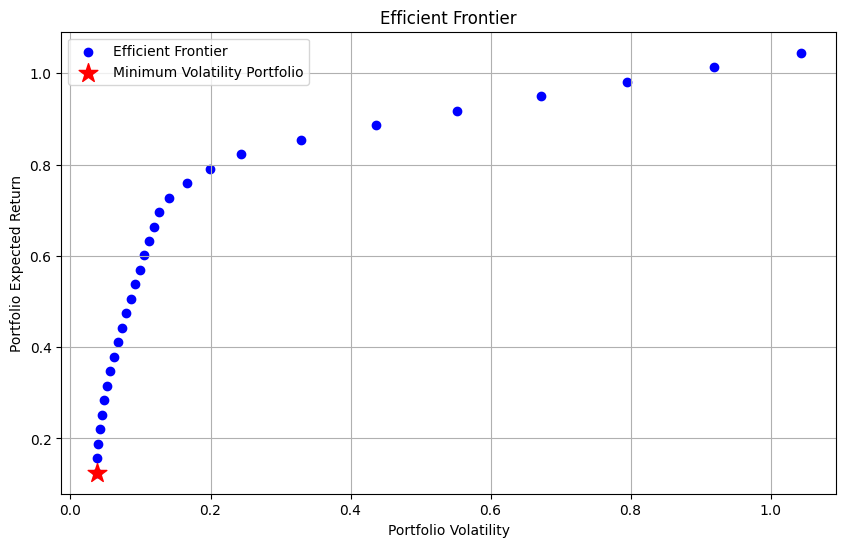

In [11]:
# We plot the efficient frontier
plt.figure(figsize=(10, 6))

plt.scatter(efficient_frontier_volatility, efficient_frontier_returns, marker='o', color='blue', label='Efficient Frontier')
plt.scatter(min_vol_port_std, min_vol_port_return, color='red', marker='*', s=200, label='Minimum Volatility Portfolio')

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')

plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(f"The volatility and the returns of the minimimum volatility portfolio are the following: \n Volatility: {round(min_vol_port_std,2)} \n Returns: {round(min_vol_port_return,2)}")

The volatility and the returns of the minimimum volatility portfolio are the following: 
 Volatility: 0.04 
 Returns: 0.13


In [18]:
min_vol_w_df = pd.DataFrame({"Weigths": min_vol_weights, "Assets": assets_df.columns})

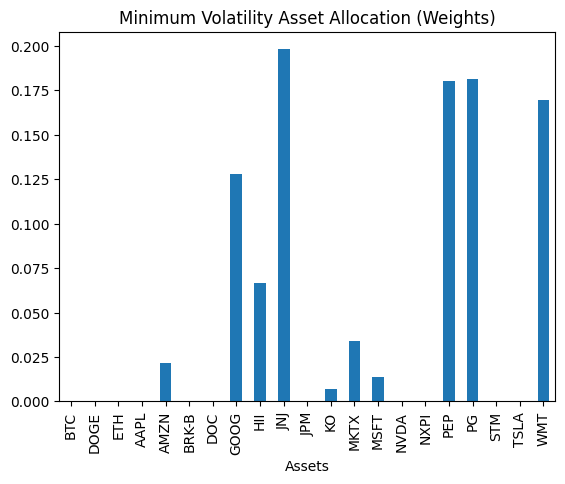

In [37]:
min_vol_w_df.set_index("Assets").plot.bar(title = "Minimum Volatility Asset Allocation (Weights)", legend = False);

# Time and volatility comparison between BTC and other assets

First of all, we need to define some functions.

In [50]:
# Function that plots a gaussian fit comparison of btc and asset_to_comp 
def plot_return_distributions(btc, asset_to_comp, asset_name, ax):

    # Generates probability density function of Bitcoin's returns (Gaussian fit)
    # Turns the time-series of prices into returns
    btc_returns = np.diff(np.log(btc))
    # Fits a Gaussian on the distribution of returns
    btc_mu, btc_std = norm.fit(btc_returns)
    # Generates the x coordinates for the density function
    x_btc = np.linspace(min(btc_returns), max(btc_returns), 100)
    # Generates the pdf
    pdf = norm.pdf(x_btc, btc_mu, btc_std)

    # We do the same as above with the asset we compare to Bitcoin
    asset_returns = np.diff(np.log(asset_to_comp)) 
    asset_mu, asset_std = norm.fit(asset_returns)
    x_asset = np.linspace(min(asset_returns), max(asset_returns), 100)
    pdf_asset = norm.pdf(x_asset, asset_mu, asset_std)

    # We plot the two distributions
    ax.plot(x_btc, pdf, 'g-', label='Bitcoin')
    ax.plot(x_asset, pdf_asset, 'r-', label=f"{asset_name}")
    ax.set_title(f"Annual Return Distributions")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.set_xlim(min([min(btc_returns), min(asset_returns)]), max([max(btc_returns), max(asset_returns)]))
    ax.legend()

# This function plots the log scaled time series of Bitcoin and the asset we compare it with
def plot_log_time_series(btc, asset_to_comp, asset_name, ax):
    # Time series on log scale - last 10 yrs
    # First we normalize our data to view it in terms of relative performance compared to the starting price (we do this for both Bitcoin and the other asset)
    ax.plot(np.linspace(0, 10, len(btc)), btc/ btc[0], 'g-',  label="Bitcoin")
    ax.plot(np.linspace(0, 10, len(asset_to_comp)), asset_to_comp / asset_to_comp[0], 'r-', label=asset_name)
    ax.set_title(f"Time series (Log Scale)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Appreciation/Depreciation")
    # Here we set the log scale for y
    ax.set_yscale("log")
    ax.legend()

def plot_lin_time_series(btc, asset_to_comp, asset_name, ax, period_length, periods_per_interval):
    # We take the data for the 2 assets for the past 350 observations
    p1 = btc[-period_length:-1]
    p2 = asset_to_comp[-period_length:-1]

    # We create a line plot for the two prices and plot it
    ax.plot(np.linspace(0, periods_per_interval, len(p1)), p1/ p1[0], 'g-', label="Bitcoin")
    ax.set_title(f"Time series (Lin Scale): Bitcoin vs {asset_name}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Price Relative to Period Start")

    ax2 = ax.twinx()
    ax2.plot(np.linspace(0, periods_per_interval, len(p2)), p2 / p2[0], 'r-' , label=asset_name)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    ax.legend(lines + lines2, labels + labels2, loc='upper left')

# We ultimately put everything together into a function that plots several graphs to compare the performance of our target asset with Bitcoin
def compare_with_btc(btc_prices, asset_prices, asset_name, period_length, periods_per_interval):

    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Use consistent time period (e.g., last year) for all plots
    common_len = min(len(btc_prices), len(asset_prices))
    btc_prices = btc_prices[-common_len:]
    asset_prices = asset_prices[-common_len:]

    plot_log_time_series(btc_prices, asset_prices, asset_name, axs[0])
    plot_return_distributions(btc_prices, asset_prices, asset_name, axs[1])
    plot_lin_time_series(btc_prices, asset_prices, asset_name, axs[2], period_length, periods_per_interval)    

    plt.tight_layout()
    plt.show()

In [44]:
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period="10y").resample("M").last()
btc_prices = btc_hist["Close"].values

# A general function to automate the fetching process for the financial data of the other asset (it resamples daily data into monthly data)
def fetch(asset_ticker, period="10y"):
    asset = yf.Ticker(asset_ticker)
    asset_hist = asset.history(period=period).resample("M").last()
    
    asset_prices = asset_hist["Close"].values
    return asset_prices

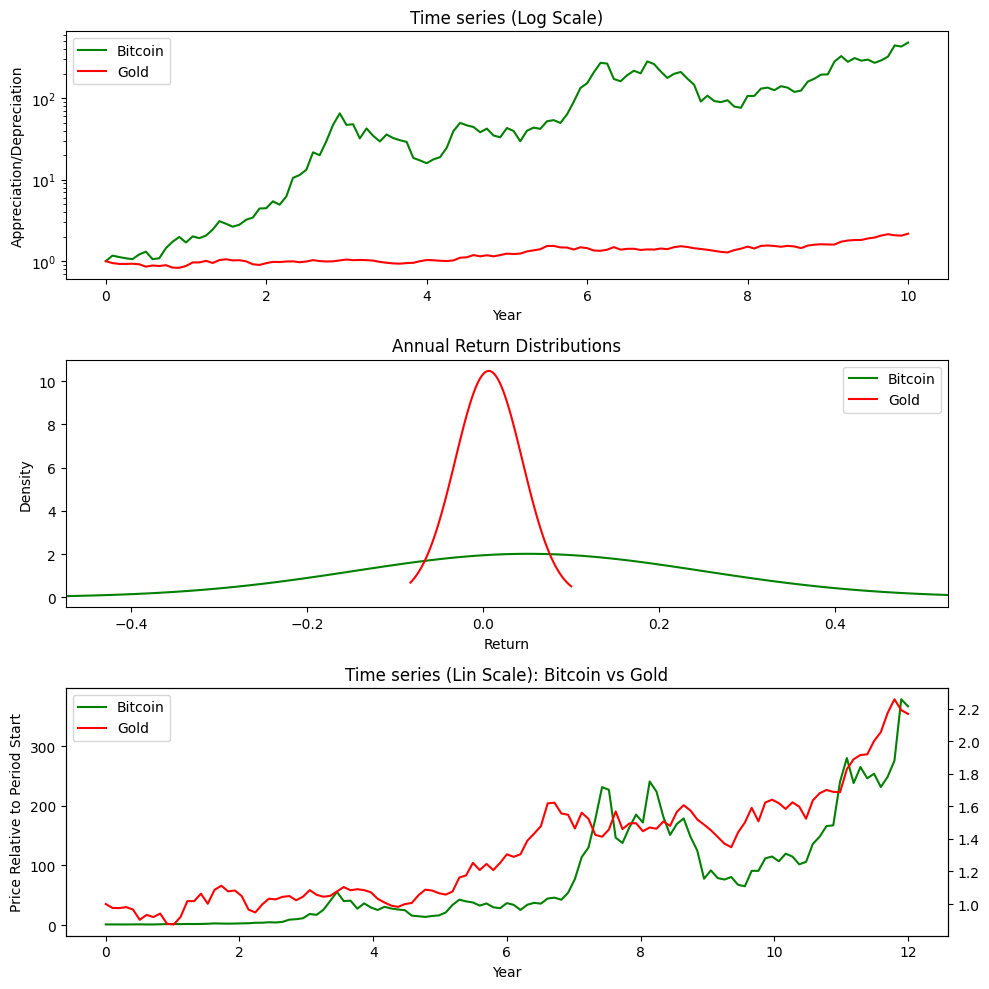

In [47]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("GC=F"), asset_name="Gold", period_length= 120, periods_per_interval= 12 )

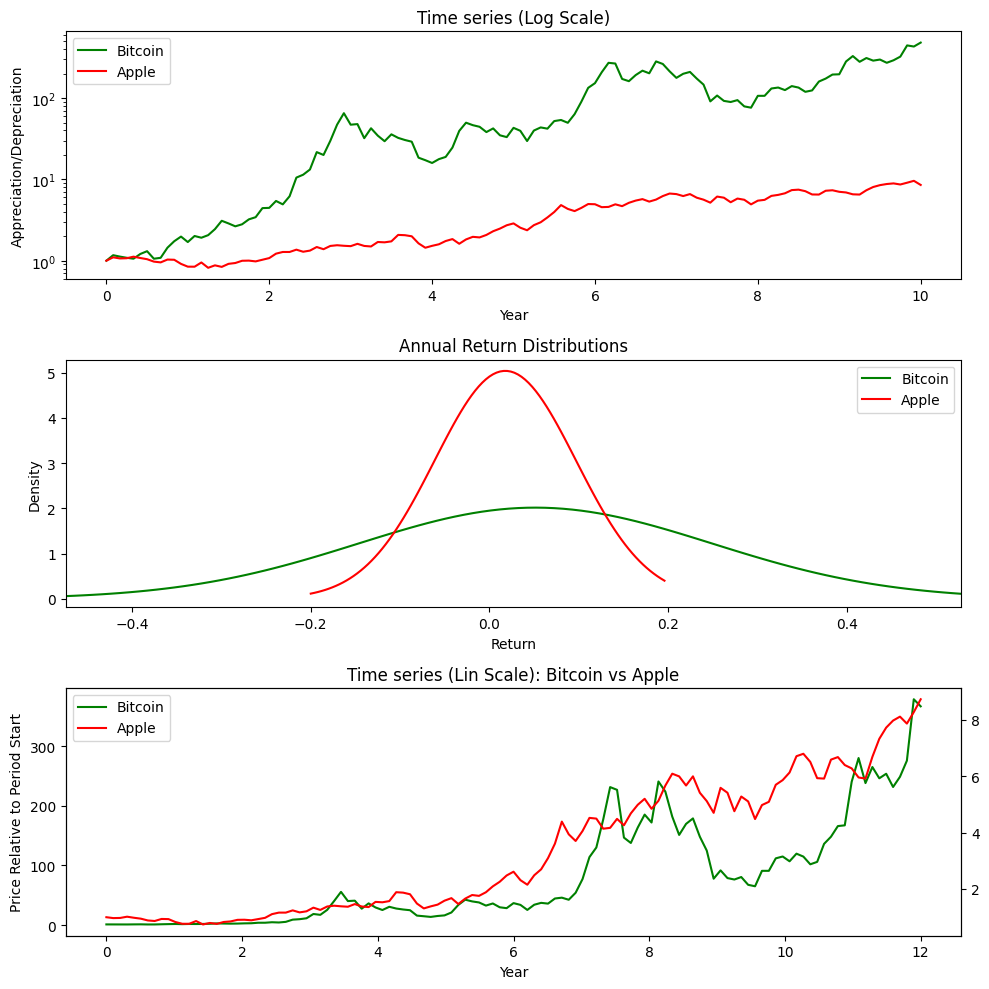

In [48]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("AAPL"), asset_name="Apple", period_length= 120, periods_per_interval= 12)

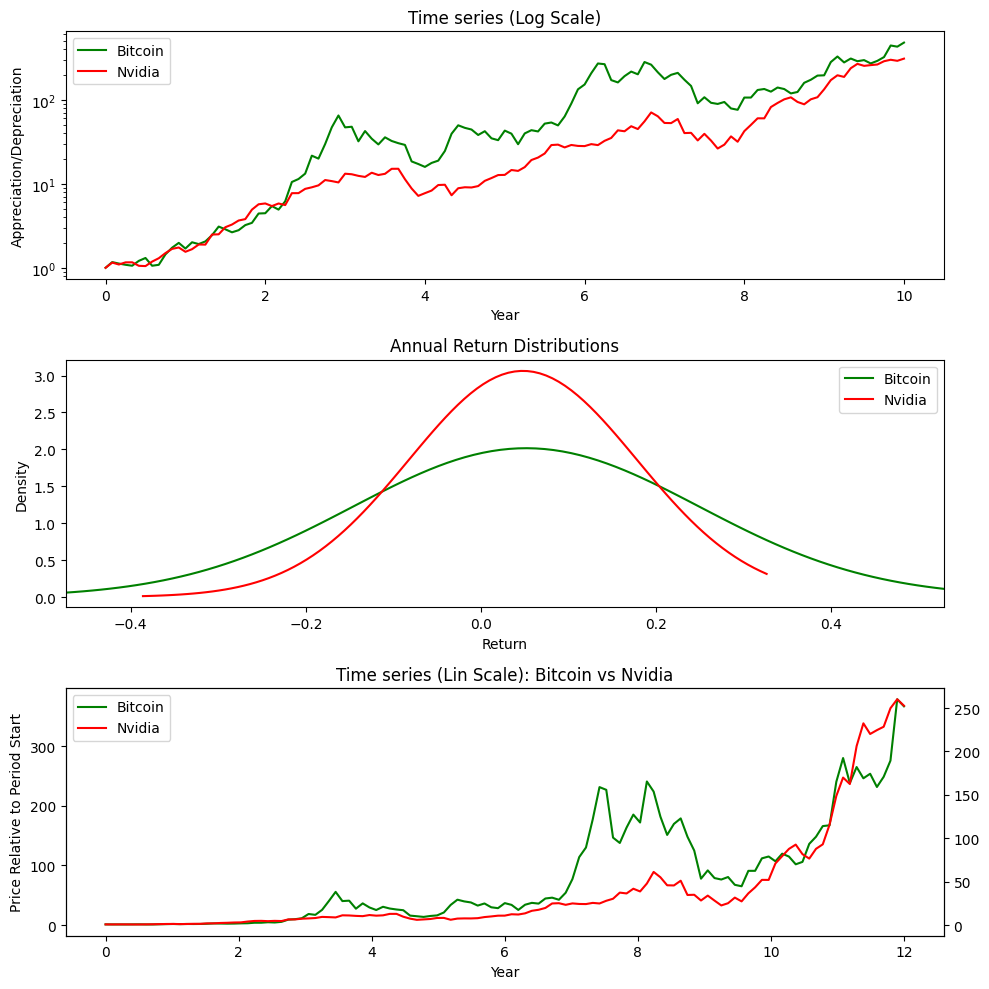

In [49]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("NVDA"), asset_name="Nvidia", period_length= 120, periods_per_interval= 12)

As we can see from the graphs above, Bitcoin's distribution of monthly returns has generally fatter tails compared to the other assets, including Nvidia, so it's more volatile and risky. However, this increased risk is balanced by a premium that we can see in average return. Indeed, Bitcoin has, in practice, outperformed all the other stocks we've compared it with in terms of % growth

# Investment Strategy with CPPI

**CPPI** stands for Constant Proportion Portfolio Insurance (CPPI). 
It's an investment strategy which allows an investor to maintain exposure to the upside potential of a risky asset while providing a capital guarantee against downside risk (Reference: *Investopedia*).

We assume that our portfolio will be rebalanced on a monthly basis. We're working in a simplified scenario, where we neglect factors such as transaction costs that in the real world would be meaningful to consider.

In [38]:
def cppi(risky_r, start, floor, m, rf_rate):
    """    
    risky_r is the time-series of the risky asset(s) in which we're going to invest

    m is the multiplier. Different values of the multiplier refer to different amounts of risk that an investor
    is willing to undertake.

    start is the wealth we start with.

    floor, express in % is the minimum % of wealth that we want to retain
    """
    dates = risky_r.index
    n_steps = len(dates)

    # We define the wealth we start with
    account_value = start

    floor_value = start*floor

    safe_r = pd.DataFrame().reindex_like(risky_r)
    safe_r[:]=rf_rate/12

    # We define 3 dataframes
        # Account history -> the history of the value of our investment per asset
    account_history = pd.DataFrame().reindex_like(risky_r)
        # The historical level of our cushion, so of the wealth "in excess"
    cushion_history = pd.DataFrame().reindex_like(risky_r)
        # The history of the wealth we put in risky assets
    risky_w_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        # We define the cushion, which depends on the current account value
        # It's the % of wealth we have in excess over our floor_value
        cushion = (account_value - floor_value)/account_value
        
        # We define the proportion wealth that we'll put into risky assets
        risky_w = m*cushion
        # We cap the proportion of risky wealth to 1 and to a minimum of 0
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)

        # We define the proportion of wealth invested in the risk-free rate
        safe_w = 1 - risky_w

        # We define the wealth allocated in risky and safe assets
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        
        #Update the account value
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        
        #Save the values so I can look at the history and plot it
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value 
    return cushion_history, risky_w_history, account_history
    

In [39]:
acc_hist, risky_hist, acc_hist = cppi(assets_df["2018":], 1000, 0.8, 3, 0.03)

In [40]:
start = 1000
floor = 0.8
floor_value = start*floor

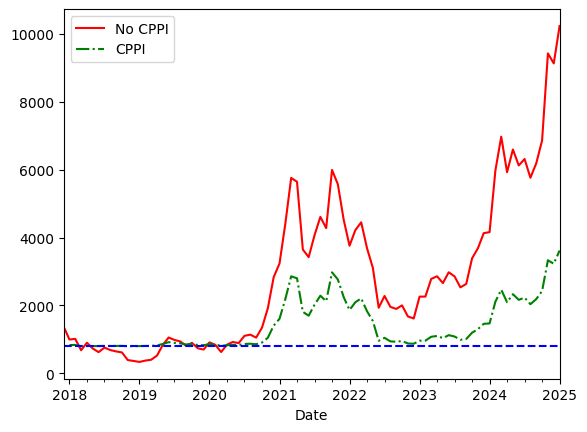

In [41]:
risky_wealth  = start*(1+assets_df).cumprod();
risky_wealth["BTC"].plot(color = "red", legend = True, label = "No CPPI");
ax = acc_hist["BTC"].plot(color = "green", legend = True, label = "CPPI", style = "-.");
ax.axhline(y=floor_value, color = "blue", linestyle = "--");

As we can see, while the CPPI didn't allow us to fully capture the upside of the last bull-run, during the crypto-winter of 2020 it still allowed us not to go below the floor level.

<Axes: xlabel='Date'>

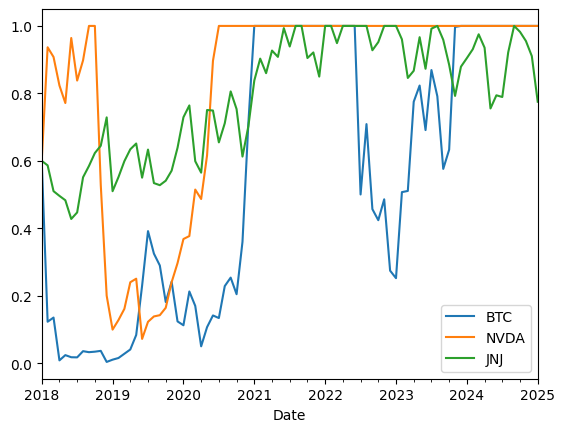

In [42]:
risky_hist[["BTC", "NVDA", "JNJ"]].plot()

In [43]:
# Now we have a look at what the performance of the various assets would've been had we used the CPPI strategy with each of them
# One at a time
get_comparative_stats(acc_hist)

,BTC,DOGE,ETH,AAPL,AMZN,BRK-B,DOC,GOOG,HII,JNJ,...,KO,MKTX,MSFT,NVDA,NXPI,PEP,PG,STM,TSLA,WMT
Mean,0.026565,0.125829,-0.003873,0.021337,0.017818,0.009317,0.001262,0.015883,-0.001155,0.001864,...,0.004882,0.004412,0.02079,0.041382,0.000766,0.004513,0.009945,0.000706,0.040968,0.013568
Standard Deviation,0.1356,0.68431,0.043471,0.080253,0.08926,0.047702,0.055775,0.067589,0.043692,0.038591,...,0.044714,0.101207,0.059384,0.128463,0.051223,0.039487,0.04667,0.079689,0.178902,0.049974
Skewness,0.501211,5.736979,-5.550567,-0.031009,0.143717,-0.158986,-1.017432,-0.253642,-1.557911,-0.198542,...,-0.877159,0.493151,0.031286,0.094518,-0.377666,0.180406,0.120871,0.138438,1.025103,-0.24857
Kurtosis,2.276362,37.63673,32.578037,-0.441169,0.897229,-0.216678,3.36956,-0.077089,5.95719,-0.396959,...,1.421269,1.61032,-0.292662,0.349672,0.298745,-0.213472,-0.120687,0.919235,1.914279,0.947468
Normality,0,0,0,1,1,1,0,1,0,1,...,0,0,1,1,1,1,1,1,0,1
Max Drawdown,0.71,0.82,0.3,0.26,0.52,0.24,0.42,0.4,0.28,0.17,...,0.23,0.65,0.31,0.63,0.32,0.18,0.21,0.46,0.68,0.2
Max Drawdown Date,2022-12-31,2022-08-31,2018-03-31,2022-12-31,2022-12-31,2022-09-30,2023-10-31,2022-12-31,2024-10-31,2024-04-30,...,2020-03-31,2024-04-30,2022-10-31,2022-09-30,2022-10-31,2025-01-31,2022-09-30,2024-12-31,2022-12-31,2022-06-30
Semideviation,0.09,0.11,0.1,0.04,0.05,0.03,0.04,0.04,0.04,0.02,...,0.04,0.06,0.03,0.08,0.03,0.02,0.02,0.05,0.08,0.03
Historical VaR,-167.159966,-249.180166,-23.147897,-109.197337,-110.940529,-63.457388,-85.503628,-99.97802,-60.618487,-68.627974,...,-81.962728,-159.384024,-73.528231,-168.742594,-73.637617,-56.29333,-71.761635,-119.844668,-196.536167,-58.871371
CVaR,-251.933952,-316.314843,-131.531065,-129.904658,-159.484022,-84.163297,-133.944456,-128.724429,-116.693661,-76.24718,...,-106.487301,-196.037157,-88.627213,-224.503614,-108.252106,-66.790498,-83.363131,-169.236959,-246.897394,-93.303945


As we can see, typically under the CPPI the returns given by risky assets see a decrease in Sharpe Ratio, but also in volatility.

Now, let's have a look at how our minimum volatility portfolio would have performed with the CPPI.
Let's try with a higher multiplier, to see how the CPPI behaves, as we're already choosing a very risk-limiting portfolio.

In [44]:
minimum_volatility_ts = pd.DataFrame(min_vol_weights@assets_df.T)
minimum_volatility_ts.columns = ["No CPPI"]

In [45]:
acc_hist_minvol, risky_hist_minvol, acc_hist_minvol = cppi(minimum_volatility_ts["2018":], 1000, 0.8, 7, 0.03)

In [46]:
start = 1000
floor = 0.8
floor_value = start*floor

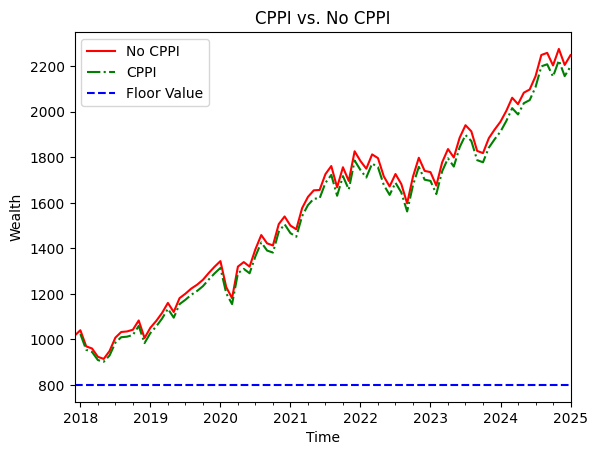

In [47]:
min_vol_risky_wealth = start*(1+minimum_volatility_ts).cumprod()


fig, ax = plt.subplots()
min_vol_risky_wealth.plot(color = "red", legend = True, label = "No CPPI", ax=ax) 
acc_hist_minvol.columns = ["CPPI"]
acc_hist_minvol.plot(color = "green", legend = True, label = "CPPI", style = "-.", ax=ax)
ax.axhline(y=floor_value, color="blue", linestyle="--", label="Floor Value") 

ax.set_title("CPPI vs. No CPPI")
ax.set_xlabel("Time")
ax.set_ylabel("Wealth")

plt.legend()
plt.show()

As expected, with a high multiplier, the CPPI doesn't really yield any positive effect and is not particularly useful. At the same time, however, it's also important to note that the weights for the minimum variance portfolio were calculated from an ex-post perspective. so this may not necessarily represent a realistic result.